<a href="https://colab.research.google.com/github/Shrinjoymaiti/pycourse/blob/master/Lecture_7_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task
*   Download another well's real-time data from Volve field. (https://data.equinor.com/dataset/Volve )
*   Parse the Trajectory and Log Data
*   Plot the Trajectory
*   Plot the Real-Time Data

### Bonus task
*   Summarize the rig activities according to Time
    ( Find Total Duration for each Rig activity )
*   Write a function for Unit Conversion of Trajectory Data



In [1]:
import gdown

! gdown -O data.zip https://drive.google.com/uc?id=1L9iFeMun84R5_SOwKXZ6VtPTGwh4Ser6


Downloading...
From: https://drive.google.com/uc?id=1L9iFeMun84R5_SOwKXZ6VtPTGwh4Ser6
To: /content/data.zip
24.7MB [00:00, 67.7MB/s]


In [ ]:
!unzip data.zip

In [91]:
traj_path='/content/data/15_9-F-4/1/trajectory/1.xml'

In [92]:
!pip install xmltodict

In [93]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import os
import json
import xmltodict

In [12]:
with open(traj_path) as xml_file:
  data_dict=xmltodict.parse(xml_file.read())
xml_file.close()

In [25]:
traj_df=json_normalize(data_dict['trajectorys']['trajectory']['trajectoryStation'])
traj_df.head(5)

,@uid,dTimStn,typeTrajStation,md.@uom,md.#text,tvd.@uom,tvd.#text,incl.@uom,incl.#text,azi.@uom,azi.#text,dispNs.@uom,dispNs.#text,dispEw.@uom,dispEw.#text,vertSect.@uom,vertSect.#text,dls.@uom,dls.#text,commonData.sourceName,commonData.dTimCreation,commonData.dTimLastChange,commonData.itemState,typeSurveyTool,gravAccelCorUsed,magXAxialCorUsed,sagCorUsed,magDrlstrCorUsed,statusTrajStation,rateTurn.@uom,rateTurn.#text,rateBuild.@uom,rateBuild.#text,corUsed.stnGridCorUsed.@uom,corUsed.stnGridCorUsed.#text,corUsed.dirSensorOffset.@uom,corUsed.dirSensorOffset.#text,commonData.priv_customData
0,5VIRG33_TIE_POINT,2016-09-30T09:59:00.000Z,tie in point,m,0,m,0,rad,0,rad,0,m,0,m,0,m,0,rad/m,0,Baker Hughes,2016-09-30T11:36:15.398Z,2016-09-30T11:36:15.398Z,actual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,349VIRG33,2016-09-30T10:16:10.000Z,gyro north seeking,m,0.899999976158142,m,0.899999976158142,rad,0,rad,0,m,0,m,0,m,0,rad/m,0,Baker Hughes,2016-09-30T11:36:15.398Z,2016-09-30T11:36:15.398Z,actual,gyroscopic north seeking,false,false,false,false,position,rad/m,0,rad/m,0,rad,999.25,m,0,"SurveyQC=3,SurveyFlags=2"
2,350VIRG33,2016-09-30T10:16:10.000Z,gyro north seeking,m,184.119995117188,m,184.119902097195,rad,0.00174532927809565,rad,4.07098048049578,m,-0.0956658632801162,m,-0.128112127864178,m,-0.0956658632801162,rad/m,9.52586685058553E-06,Baker Hughes,2016-09-30T11:36:15.398Z,2016-09-30T11:36:15.398Z,actual,gyroscopic north seeking,false,false,false,false,position,rad/m,-0.0120740355923772,rad/m,9.525866516924E-06,rad,999.25,m,0,"SurveyQC=3,SurveyFlags=2"
3,351VIRG33,2016-09-30T10:16:10.000Z,gyro north seeking,m,224.449996948242,m,224.449798435682,rad,0.00279252674092332,rad,3.97202034386031,m,-0.154708942398546,m,-0.197881974514614,m,-0.154708942398546,rad/m,2.65243256384831E-05,Baker Hughes,2016-09-30T11:36:15.398Z,2016-09-30T11:36:15.398Z,actual,gyroscopic north seeking,false,false,false,false,position,rad/m,-0.00245375977829099,rad/m,2.59657190326834E-05,rad,999.25,m,0,"SurveyQC=3,SurveyFlags=2"
4,352VIRG33,2016-09-30T10:16:10.000Z,gyro north seeking,m,264.790008544922,m,264.788040577866,rad,0.0146607652598103,rad,3.81668588063479,m,-0.423542432270751,m,-0.424266903996858,m,-0.42354243227075,rad/m,0.000295232913895919,Baker Hughes,2016-09-30T11:36:15.398Z,2016-09-30T11:36:15.398Z,actual,gyroscopic north seeking,false,false,false,false,position,rad/m,-0.0038506300188601,rad/m,0.000294205121463165,rad,999.25,m,0,"SurveyQC=3,SurveyFlags=2"


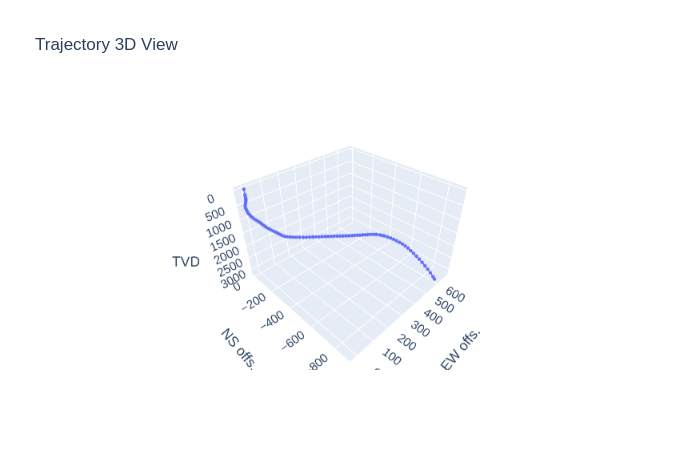

In [81]:
import plotly.graph_objects as go
zdata ='tvd.#text'
xdata ='dispEw.#text'
ydata ='dispNs.#text'
fig=go.Figure(data=go.Scatter3d(x=traj_df[xdata],y=traj_df[ydata], z=traj_df[zdata], 
                                marker=dict(size=2)))
fig.layout={'title':'Trajectory 3D View','height': 1400,
              'width': 1400,
              'scene': {'xaxis': {'title': 'EW offs.', 'autorange': "reversed"},
                        'yaxis': {'title': 'NS offs.', 'autorange': "reversed"},
                        'zaxis': {'title': 'TVD', 'autorange': "reversed"},
                        'aspectratio': {'x': 1, 'y': 1, 'z': 0.7},
                        'aspectmode': 'manual'}}
fig.show('png')

In [110]:
#Parsing real time log data
def list_files(dirName):
  listOfFiles = list()
  for (dirpath, dirnames, filenames) in os.walk(dirName):
      listOfFiles += [os.path.join(dirpath, file) for file in filenames]
  return listOfFiles
xml_log_files = [x for x in list_files('/content/data/15_9-F-4/1/log') if '.xml' in x]
xml_log_files[:5]

['/content/data/15_9-F-4/1/log/1/3/1/00002.xml',
 '/content/data/15_9-F-4/1/log/1/3/1/00001.xml',
 '/content/data/15_9-F-4/1/log/1/3/1/00003.xml',
 '/content/data/15_9-F-4/1/log/1/3/1/00004.xml',
 '/content/data/15_9-F-4/1/log/1/9/1/00002.xml']

In [114]:
#defining a function to parse the xml files 
def parse_one_log_file(f):
    with open(f) as xml_file:
        data_dict = xmltodict.parse(xml_file.read())
    xml_file.close()
    log_df = pd.DataFrame(data_dict['logs']['log']['logData']['data'])[0].str.split(",", expand=True)
    mnemonicList = data_dict['logs']['log']['logData']['mnemonicList'].split(',')
    log_df.columns = mnemonicList
    units = data_dict['logs']['log']['logData']['unitList'].split(',')
    raw_log_units = dict(zip(mnemonicList, units))
    raw_log_units_df = pd.DataFrame(raw_log_units, index=[0])
    one_log_df = pd.concat([raw_log_units_df, log_df])
    return one_log_df

#Unit Conversion
logs_unit_multipliers = {'m':1,'M':1,'ton':1,'t':1,'bar':1,'m3/s':1,'m3':1,'m/h':1,'rpm':1,'1/min':1,'N.m':1,'kkgf':1,
                      'FT':0.3048,'N':0.00010197162129779283,'L/min':1.6666666666666667e-05,
                      'Pa':1.00e-05,'kPa':0.01,'m/s':3600.0,'c/s':60.0,'1/s':60.0,'rev/s':60.0,
                      'psi':0.0689476,'kN.m':1000.0,'Euc':1,'Hz':60.0,'K':1,'ohm.m':1,'s':1,'unitless':'unitless'}

def logs_unit_conversion(df):
    df_units = df.iloc[:1,:].to_dict('records')[0]
    multipliers = {c:logs_unit_multipliers.get(df_units[c],'no_unit_found') for c in df_units}
    rtdd_df = df.iloc[1:,:].copy()
    num_columns = [x for x in multipliers if multipliers[x] not in ['no_unit_found','unitless']]
    for cn in num_columns:
        rtdd_df[cn] = pd.to_numeric(rtdd_df[cn],errors='coerce')
    nuf_columns = [x for x in multipliers if multipliers[x]=='no_unit_found']
    rtdd_df.drop(columns=nuf_columns,inplace=True)
    if 'Time' in rtdd_df.columns:
        rtdd_df['Time'] = pd.to_datetime(rtdd_df['Time'], utc=True,format="%Y-%m-%dT%H:%M:%S.%fZ")
    elif 'TIME' in rtdd_df.columns:
        rtdd_df['TIME'] = pd.to_datetime(rtdd_df['TIME'], utc=True,format="%Y-%m-%dT%H:%M:%S.%fZ")
    return rtdd_df


#to parse all the log values
all_lig_df=pd.DataFrame()
for f in xml_log_files:
  one_log_df=parse_one_log_file(f)
  corrected_one_log=logs_unit_conversion(one_log_df)
  all_lig_df=pd.concat([all_lig_df,corrected_one_log])

In [119]:
all_lig_df.head(5)

,Time,TOTGAS2,CO2_3,H2S7,TOTGAS6,H2S3,TOTGAS,CO2,H2S1,RigActivityCode,TOTGAS3,H2S2,H2S8,H2S5,TOTGAS4,H2S4,CO2_2,H2S6,TOTGAS5,Depth,EditFlag,NORMGAS,FLOWIN,FRACBITLOSS,JETVEL,BITDEP,BITLOSS,DSTRINGLOSS,ANNVEL_MMAX,FLOWOUTPC,MWDLOSS,CALCOBS,MOTORLOSS,SURFLOSS,ANNVEL_MMIN,PUMP,IMPACT,HCCI,FLOWOUT,ANNLOSS,...,CHOKE_PRESS,ONBOTTOM_TIME,I_MSE,STRATE4,BIT_RPM_MAX,DMSE,OFFBOTTOM_TIME,KILL_HIGH,MTIN,DWOR,TORQUE_MIN,BIT_RPM_MIN,MSE,TORQUE_AVG,FLOWOUT_CORIOLIS,LAG_TIME_WELLHD,MOTOR_RPM,ROT_TIME,PUMP2,LAG_WELLHD_STKS,WOB_MAX,KILL_PRESS,MTOUT,BIT_RPM_AVG,MRIN,I_BITAGG,BST_STROKESUM,WOB_AVG,STRATESUM,LAG_TIME_RISER,CUMCIRCTIME,BITVELOCITY,TOTGAS_AVG,BIT_DIST,SURF_REVS,TOTGAS_MAX,PUMP_MIN,PUMP_AVG,PUMP_MAX,TBR
0,2016-10-02 03:43:45+00:00,0.0,0.0,0.0,0.0,-1.455680e-08,0.000006,0.0,2.072940e-08,114,0.0,3.905830e-08,0.0,1.747390e-07,0.0,4.331230e-08,0.0,0.0,0.0,3510.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-10-02 03:44:00+00:00,0.0,0.0,0.0,0.0,-1.273530e-08,0.000006,0.0,1.914930e-08,114,0.0,3.763520e-08,0.0,1.749280e-07,0.0,4.161940e-08,0.0,0.0,0.0,3510.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-10-02 03:44:15+00:00,0.0,0.0,0.0,0.0,-1.414320e-08,0.000006,0.0,1.881750e-08,114,0.0,3.923040e-08,0.0,1.752150e-07,0.0,4.134710e-08,0.0,0.0,0.0,3510.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-10-02 03:44:30+00:00,0.0,0.0,0.0,0.0,-1.382300e-08,0.000006,0.0,1.910360e-08,114,0.0,3.900220e-08,0.0,1.737890e-07,0.0,4.152880e-08,0.0,0.0,0.0,3510.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-10-02 03:44:45+00:00,0.0,0.0,0.0,0.0,-1.313320e-08,0.000006,0.0,1.864470e-08,114,0.0,4.021640e-08,0.0,1.745770e-07,0.0,4.197420e-08,0.0,0.0,0.0,3510.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
#Checking out the various columns of dataframe
all_lig_df.columns.to_list()[:35]

['Time',
 'TOTGAS2',
 'CO2_3',
 'H2S7',
 'TOTGAS6',
 'H2S3',
 'TOTGAS',
 'CO2',
 'H2S1',
 'RigActivityCode',
 'TOTGAS3',
 'H2S2',
 'H2S8',
 'H2S5',
 'TOTGAS4',
 'H2S4',
 'CO2_2',
 'H2S6',
 'TOTGAS5',
 'Depth',
 'EditFlag',
 'NORMGAS',
 'FLOWIN',
 'FRACBITLOSS',
 'JETVEL',
 'BITDEP',
 'BITLOSS',
 'DSTRINGLOSS',
 'ANNVEL_MMAX',
 'FLOWOUTPC',
 'MWDLOSS',
 'CALCOBS',
 'MOTORLOSS',
 'SURFLOSS',
 'ANNVEL_MMIN']

In [130]:
col=['Time','Depth','BITDEP','BITLOSS','FLOWOUT']
tempdf=all_lig_df.loc[:,col].dropna(subset=['Time']).set_index('Time').sort_index()
tempdf

,Depth,BITDEP,BITLOSS,FLOWOUT
Time,,,,
2016-09-30 10:04:00+00:00,0.000000,NaN,NaN,NaN
2016-09-30 10:04:01+00:00,0.000000,0.000000,NaN,0.000256
2016-09-30 10:04:01+00:00,0.000000,NaN,NaN,NaN
2016-09-30 10:04:01+00:00,0.000000,0.000000,NaN,NaN
2016-09-30 10:04:01+00:00,0.000000,NaN,NaN,NaN
...,...,...,...,...
2016-10-07 08:11:30+00:00,3510.000000,2.432163,NaN,0.000282
2016-10-07 08:11:30+00:00,2.432163,NaN,NaN,NaN
2016-10-07 08:11:32+00:00,3510.000000,2.432163,NaN,0.000282


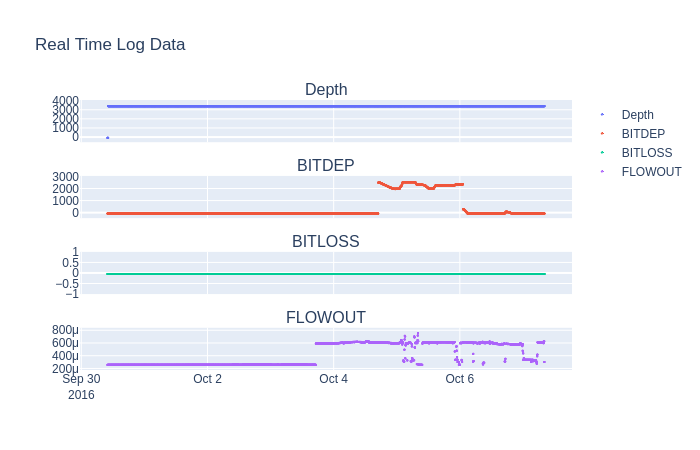

In [155]:
df=tempdf.resample('5T').median()
#Plotting Real Time Data

from plotly import subplots
fig = subplots.make_subplots(rows=df.shape[1],cols=1,print_grid=False,shared_xaxes=True,subplot_titles=tuple(list(df.columns)))
i=1
for c in df.columns:
    fig.add_trace(go.Scattergl(x=df.index,y=df[c],name=c,mode='markers',marker=dict(size=2)),i,1)
    i = i + 1
fig['layout'].update( title='Real Time Log Data')
fig.show('png')

#BONUS TASK


In [ ]:
rig_dict=all_lig_df['RigActivityCode'].unique().tolist()
total=[]
for i in rig_dict:
  t=all_lig_df['Time']
  c=t.sum()
  total[i]=c
total